## Relevant libraries and methods

In [165]:
import os
import glob

# Data handling and manipulation library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [166]:
pharDf = pd.read_csv('data_processed\sales_insights_pharmacy_cleaned.csv', delimiter=',')
hospDf = pd.read_csv('data_processed\sales_insights_hospital_cleaned.csv', delimiter=',')

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Victo\AppData\Local\Temp\ipykernel_34924\2386274991.py:1: SyntaxWarning: invalid escape sequence '\s'
  pharDf = pd.read_csv('data_processed\sales_insights_pharmacy_cleaned.csv', delimiter=',')
C:\Users\Victo\AppData\Local\Temp\ipykernel_34924\2386274991.py:2: SyntaxWarning: invalid escape sequence '\s'
  hospDf = pd.read_csv('data_processed\sales_insights_hospital_cleaned.csv', delimiter=',')


In [167]:
print(len(pharDf))
print(len(hospDf))
print(pharDf.columns)
print(hospDf.columns)

7282
4724
Index(['Account Description', 'Size', 'Size Numeric', 'Strength (mg)',
       'WHO ATC 5 Code', 'Volume', 'Value', 'Year Month (after 2000)',
       'Year (after 2000)', 'Month', 'Region_Færøerne', 'Region_Hovedstaden',
       'Region_Midtjylland', 'Region_Nordjylland', 'Region_Sjælland',
       'Region_Syddanmark', 'Product_Cimzia', 'Product_Inflectra',
       'Product_Remicade', 'Product_Remsima', 'Product_Stelara',
       'Product_Zessly'],
      dtype='object')
Index(['Account Description', 'Size', 'Size Numeric', 'Strength (mg)',
       'WHO ATC 5 Code', 'Volume', 'Value', 'Year Month (after 2000)',
       'Year (after 2000)', 'Month', 'Region_Hovedstaden',
       'Region_Midtjylland', 'Region_Nordjylland', 'Region_Sjælland',
       'Region_Syddanmark', 'Product_Cimzia', 'Product_Inflectra',
       'Product_Remicade', 'Product_Remsima', 'Product_Stelara',
       'Product_Zessly'],
      dtype='object')


#### Merge datasets phar and hosp insights and remove unwanted columns + duplicates

In [168]:
# Merge the two datasets together
merged_df = pd.concat([pharDf, hospDf], ignore_index=True)

# remove the column 'Region_Færøerne'
merged_df = merged_df.drop(columns=['Region_Færøerne'])

# drop duplicates in pharmacy_df
merged_df_no_Dups = merged_df.drop_duplicates()

# convert the float to int in column 'Year Month (after 2000)'.
# merged_df_no_Dups['Year Month (after 2000)'] = merged_df_no_Dups['Year Month (after 2000)'].astype(int)

print(len(merged_df_no_Dups))

7282


#### Divide the dataset into two subdatasets: Hospital and Pharmacy

In [169]:
hospitalDf = merged_df_no_Dups[~merged_df_no_Dups['Account Description'].str.contains('Apotek', case=False)]
pharmacyDf = merged_df_no_Dups[merged_df_no_Dups['Account Description'].str.contains('Apotek', case=False)]

print(len(hospitalDf))
print(len(pharmacyDf))

1154
6128


#### Convert Year Month to datetime object and remove year column

In [170]:
# Convert the 'Year Month (after 2000)' column to a datetime
hospitalDf['Year Month (after 2000) in Datetime'] = pd.to_datetime(hospitalDf['Year Month (after 2000)'].astype(int).astype(str), format='%y%m')
pharmacyDf['Year Month (after 2000) in Datetime'] = pd.to_datetime(pharmacyDf['Year Month (after 2000)'].astype(int).astype(str), format='%y%m')

# Remove time from the datetime object
hospitalDf['Year Month (after 2000) in Datetime'] = hospitalDf['Year Month (after 2000) in Datetime'].dt.to_period('M')
pharmacyDf['Year Month (after 2000) in Datetime'] = pharmacyDf['Year Month (after 2000) in Datetime'].dt.to_period('M')

# Convert the date object to a string
hospitalDf['Year Month (after 2000) in Datetime'] = hospitalDf['Year Month (after 2000) in Datetime'].astype(str)
pharmacyDf['Year Month (after 2000) in Datetime'] = pharmacyDf['Year Month (after 2000) in Datetime'].astype(str)

# Add the 'Year Month (after 2000) in Datetime' column to the 8th column
cols = hospitalDf.columns.tolist()
cols = cols[:8] + cols[-1:] + cols[8:-1]
hospitalDf = hospitalDf[cols]
pharmacyDf = pharmacyDf[cols]

# drop the 'Year (after 2000)' column
hospitalDf = hospitalDf.drop(columns=['Year (after 2000)'])
pharmacyDf = pharmacyDf.drop(columns=['Year (after 2000)'])

# drop the 'month' column
hospitalDf = hospitalDf.drop(columns=['Month'])
pharmacyDf = pharmacyDf.drop(columns=['Month'])

C:\Users\Victo\AppData\Local\Temp\ipykernel_34924\1147605327.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hospitalDf['Year Month (after 2000) in Datetime'] = pd.to_datetime(hospitalDf['Year Month (after 2000)'].astype(int).astype(str), format='%y%m')
C:\Users\Victo\AppData\Local\Temp\ipykernel_34924\1147605327.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pharmacyDf['Year Month (after 2000) in Datetime'] = pd.to_datetime(pharmacyDf['Year Month (after 2000)'].astype(int).astype(str), format='%y%

#### Add new Account Description ID Column

In [171]:
# Convert all values in Account Description in SortedDfApo to a numbers and store in a new column 'Account Description Number'. 
# The numbers are ascending from 100 to the number of unique values in 'Account Description'
pharmacyDf['Account Description ID'] = pd.factorize(pharmacyDf['Account Description'])[0] + 100
pharmacyDf = pharmacyDf[['Account Description ID'] + [col for col in pharmacyDf.columns if col != 'Account Description ID']]

# Convert all values in Account Description in SortedDfNonApo to a numbers and store in a new column 'Account Description Number'. 
# The numbers are ascending from 0 to the number of unique values in 'Account Description'
hospitalDf['Account Description ID'] = pd.factorize(hospitalDf['Account Description'])[0]
hospitalDf = hospitalDf[['Account Description ID'] + [col for col in hospitalDf.columns if col != 'Account Description ID']]

# merge the two dataframes
hospitalPharmacyDf = pd.concat([hospitalDf, pharmacyDf], ignore_index=True)

# move the new column as the first column
hospitalPharmacyDf = hospitalPharmacyDf[['Account Description ID'] + [col for col in hospitalPharmacyDf.columns if col != 'Account Description ID']]

hospitalPharmacyDf

,Account Description ID,Account Description,Size,Size Numeric,Strength (mg),WHO ATC 5 Code,Volume,Value,Year Month (after 2000),Year Month (after 2000) in Datetime,...,Region_Midtjylland,Region_Nordjylland,Region_Sjælland,Region_Syddanmark,Product_Cimzia,Product_Inflectra,Product_Remicade,Product_Remsima,Product_Stelara,Product_Zessly
0,0,3061 Aalborg ø Fyrkilden,1 eng. spr. a 1 ml,1.0,90.0,L04AC05,2.0,51475.62,1508.0,2015-08,...,False,True,False,False,False,False,False,False,True,False
1,0,3061 Aalborg ø Fyrkilden,1 eng. spr. a 1 ml,1.0,90.0,L04AC05,2.0,51475.62,1510.0,2015-10,...,False,True,False,False,False,False,False,False,True,False
2,0,3061 Aalborg ø Fyrkilden,1 stk. (0.5 ml),1.0,45.0,L04AC05,1.0,25737.81,1511.0,2015-11,...,False,True,False,False,False,False,False,False,True,False
3,0,3061 Aalborg ø Fyrkilden,1 eng. spr. a 1 ml,1.0,90.0,L04AC05,1.0,25737.81,1512.0,2015-12,...,False,True,False,False,False,False,False,False,True,False
4,0,3061 Aalborg ø Fyrkilden,1 eng. spr. a 1 ml,1.0,90.0,L04AC05,1.0,25737.81,1602.0,2016-02,...,False,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7277,257,4398 Viborg Sygehus. apoteket,1 htgl.,1.0,100.0,L04AB02,472.0,2028009.36,1310.0,2013-10,...,True,False,False,False,False,False,True,False,False,False
7278,257,4398 Viborg Sygehus. apoteket,2 stk.,2.0,200.0,L04AB05,45.0,354665.70,1311.0,2013-11,...,True,False,False,False,True,False,False,False,False,False
7279,257,4398 Viborg Sygehus. apoteket,1 htgl.,1.0,100.0,L04AB02,410.0,1761618.30,1311.0,2013-11,...,True,False,False,False,False,False,True,False,False,False
7280,257,4398 Viborg Sygehus. apoteket,2 stk.,2.0,200.0,L04AB05,52.0,409835.92,1312.0,2013-12,...,True,False,False,False,True,False,False,False,False,False


#### Sort hospital and pharmacy datasets into values between 2010 and 2019 and only for Stelara

In [172]:
hospitalDfYearSorted = hospitalDf[(hospitalDf['Year Month (after 2000)'] >= 1001) & (hospitalDf['Year Month (after 2000)'] <= 1912)]
PharmacyDfYearSorted = pharmacyDf[(pharmacyDf['Year Month (after 2000)'] >= 1001) & (pharmacyDf['Year Month (after 2000)'] <= 1912)]
mergedHospitalPharmacyDfYearSorted = pd.concat([hospitalDfYearSorted, PharmacyDfYearSorted], ignore_index=True)

#Stelara
hospitalDfYearAndStelaraSorted = hospitalDfYearSorted[hospitalDfYearSorted['Product_Stelara'] == True]
PharmacyDfYearAndStelaraSorted = PharmacyDfYearSorted[PharmacyDfYearSorted['Product_Stelara'] == True]
mergedHospitalPharmacyDfYearAndStelaraSorted = pd.concat([hospitalDfYearAndStelaraSorted, PharmacyDfYearAndStelaraSorted], ignore_index=True)

print('Hospital total sales btw 2010 and 2019 for Stelara: ', sum(hospitalDfYearAndStelaraSorted['Volume']))
print('Pharmacy total sales btw 2010 and 2019 for Stelara: ', sum(PharmacyDfYearAndStelaraSorted['Volume']))

#Cimzia
hospitalDfYearAndCimziaSorted = hospitalDfYearSorted[hospitalDfYearSorted['Product_Cimzia'] == True]
PharmacyDfYearAndCimziaSorted = PharmacyDfYearSorted[PharmacyDfYearSorted['Product_Cimzia'] == True]
mergedHospitalPharmacyDfYearAndCimziaSorted = pd.concat([hospitalDfYearAndCimziaSorted, PharmacyDfYearAndCimziaSorted], ignore_index=True)

print('Hospital total sales btw 2010 and 2019 for Cimzia: ', sum(hospitalDfYearAndCimziaSorted['Volume']))
print('Pharmacy total sales btw 2010 and 2019 for Cimzia: ', sum(PharmacyDfYearAndCimziaSorted['Volume']))

#Inflectra
hospitalDfYearAndInflectraSorted = hospitalDfYearSorted[hospitalDfYearSorted['Product_Inflectra'] == True]
PharmacyDfYearAndInflectraSorted = PharmacyDfYearSorted[PharmacyDfYearSorted['Product_Inflectra'] == True]
mergedHospitalPharmacyDfYearAndInflectraSorted = pd.concat([hospitalDfYearAndInflectraSorted, PharmacyDfYearAndInflectraSorted], ignore_index=True)

print('Hospital total sales btw 2010 and 2019 for Inflectra: ', sum(hospitalDfYearAndInflectraSorted['Volume']))
print('Pharmacy total sales btw 2010 and 2019 for Inflectra: ', sum(PharmacyDfYearAndInflectraSorted['Volume']))

#Remicade
hospitalDfYearAndRemicadeSorted = hospitalDfYearSorted[hospitalDfYearSorted['Product_Remicade'] == True]
PharmacyDfYearAndRemicadeSorted = PharmacyDfYearSorted[PharmacyDfYearSorted['Product_Remicade'] == True]
mergedHospitalPharmacyDfYearAndRemicadeSorted = pd.concat([hospitalDfYearAndRemicadeSorted, PharmacyDfYearAndRemicadeSorted], ignore_index=True)

print('Hospital total sales btw 2010 and 2019 for Remicade: ', sum(hospitalDfYearAndRemicadeSorted['Volume']))
print('Pharmacy total sales btw 2010 and 2019 for Remicade: ', sum(PharmacyDfYearAndRemicadeSorted['Volume']))

#Remsima
hospitalDfYearAndRemsimaSorted = hospitalDfYearSorted[hospitalDfYearSorted['Product_Remsima'] == True]
PharmacyDfYearAndRemsimaSorted = PharmacyDfYearSorted[PharmacyDfYearSorted['Product_Remsima'] == True]
mergedHospitalPharmacyDfYearAndRemsimaSorted = pd.concat([hospitalDfYearAndRemsimaSorted, PharmacyDfYearAndRemsimaSorted], ignore_index=True)

print('Hospital total sales btw 2010 and 2019 for Remsima: ', sum(hospitalDfYearAndRemsimaSorted['Volume']))
print('Pharmacy total sales btw 2010 and 2019 for Remsima: ', sum(PharmacyDfYearAndRemsimaSorted['Volume']))

#Zessly
hospitalDfYearAndZesslySorted = hospitalDfYearSorted[hospitalDfYearSorted['Product_Zessly'] == True]
PharmacyDfYearAndZesslySorted = PharmacyDfYearSorted[PharmacyDfYearSorted['Product_Zessly'] == True]
mergedHospitalPharmacyDfYearAndZesslySorted = pd.concat([hospitalDfYearAndZesslySorted, PharmacyDfYearAndZesslySorted], ignore_index=True)

print('Hospital total sales btw 2010 and 2019 for Zessly: ', sum(hospitalDfYearAndZesslySorted['Volume']))
print('Pharmacy total sales btw 2010 and 2019 for Zessly: ', sum(PharmacyDfYearAndZesslySorted['Volume']))


Hospital total sales btw 2010 and 2019 for Stelara:  7621.0
Pharmacy total sales btw 2010 and 2019 for Stelara:  23815.0
Hospital total sales btw 2010 and 2019 for Cimzia:  13481.0
Pharmacy total sales btw 2010 and 2019 for Cimzia:  66583.0
Hospital total sales btw 2010 and 2019 for Inflectra:  46652.0
Pharmacy total sales btw 2010 and 2019 for Inflectra:  197095.0
Hospital total sales btw 2010 and 2019 for Remicade:  59393.0
Pharmacy total sales btw 2010 and 2019 for Remicade:  367349.0
Hospital total sales btw 2010 and 2019 for Remsima:  51072.0
Pharmacy total sales btw 2010 and 2019 for Remsima:  248589.0
Hospital total sales btw 2010 and 2019 for Zessly:  22290.0
Pharmacy total sales btw 2010 and 2019 for Zessly:  94974.0


#### sort data into ATC5 code L04AC05

In [173]:
DfYearAndL04AC05SortedZessly = mergedHospitalPharmacyDfYearAndZesslySorted
DfYearAndL04AC05SortedRemsima = mergedHospitalPharmacyDfYearAndRemsimaSorted
DfYearAndL04AC05SortedRemicade = mergedHospitalPharmacyDfYearAndRemicadeSorted
DfYearAndL04AC05SortedInflectra = mergedHospitalPharmacyDfYearAndInflectraSorted

mergedDfYearAndL04AC05Sorted = pd.concat([DfYearAndL04AC05SortedZessly, DfYearAndL04AC05SortedRemsima, DfYearAndL04AC05SortedRemicade, DfYearAndL04AC05SortedInflectra], ignore_index=True)

#### make dataset with product fetaure for pie chart

<Axes: ylabel='Volume'>

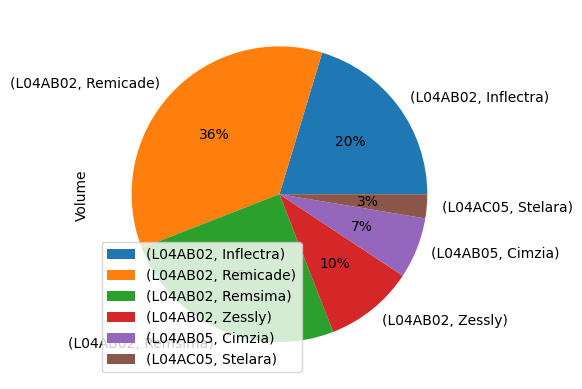

In [180]:
mergedHospitalPharmacyDfYearAndStelaraSorted['Product'] = 'Stelara'
mergedHospitalPharmacyDfYearAndCimziaSorted['Product'] = 'Cimzia'
mergedHospitalPharmacyDfYearAndInflectraSorted['Product'] = 'Inflectra'
mergedHospitalPharmacyDfYearAndRemicadeSorted['Product'] = 'Remicade'
mergedHospitalPharmacyDfYearAndRemsimaSorted['Product'] = 'Remsima'
mergedHospitalPharmacyDfYearAndZesslySorted['Product'] = 'Zessly'

mergedHospitalPharmacyDfYearAndSortedWithproduct = pd.concat([mergedHospitalPharmacyDfYearAndStelaraSorted, mergedHospitalPharmacyDfYearAndCimziaSorted, mergedHospitalPharmacyDfYearAndInflectraSorted, mergedHospitalPharmacyDfYearAndRemicadeSorted, mergedHospitalPharmacyDfYearAndRemsimaSorted, mergedHospitalPharmacyDfYearAndZesslySorted], ignore_index=True)

mergedHospitalPharmacyDfYearAndSortedWithproduct.groupby(['WHO ATC 5 Code', 'Product']).sum().plot( 
    kind='pie', y='Volume', autopct='%1.0f%%')

#### Add type column to mergedHospitalPharmacyDfYearSorted

In [ ]:
hospitalDfYearSorted['Type'] = 'Hospital'
PharmacyDfYearSorted['Type'] = 'Pharmacy'
mergedHospitalPharmacyDfYearAndSortedWithTypes = pd.concat([hospitalDfYearSorted, PharmacyDfYearSorted], ignore_index=True)

# Add the 'Type' column to the 2nd column
cols = mergedHospitalPharmacyDfYearAndSortedWithTypes.columns.tolist()
cols = cols[:1] + cols[-1:] + cols[1:-1]
mergedHospitalPharmacyDfYearAndSortedWithTypes = mergedHospitalPharmacyDfYearAndSortedWithTypes[cols]

C:\Users\Victo\AppData\Local\Temp\ipykernel_34924\3190136164.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hospitalDfYearSorted['Type'] = 'Hospital'
C:\Users\Victo\AppData\Local\Temp\ipykernel_34924\3190136164.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PharmacyDfYearSorted['Type'] = 'Pharmacy'


#### Define a dataset with data only from Central Apoteket (main pharmacy next to central station)

In [ ]:
centralPharmacy = PharmacyDfYearAndStelaraSorted[PharmacyDfYearAndStelaraSorted['Account Description'].str.contains('CentralApoteket', case=False)]

#### Draw stacked column chart of total sales of Stelara in hospitals and pharmacies btw 2010 and 2019

In [ ]:
hospitalDfYearAndStelaraSorted['Type'] = 'Hospitals'
PharmacyDfYearAndStelaraSorted['Type'] = 'Pharmacies'
mergedHospitalPharmacyDfYearAndStelaraSortedWithTypes = pd.concat([hospitalDfYearAndStelaraSorted, PharmacyDfYearAndStelaraSorted], ignore_index=True)

# Pivot the data
pivot_df_stelara = mergedHospitalPharmacyDfYearAndStelaraSortedWithTypes.pivot_table(index='Year Month (after 2000) in Datetime', columns='Type', values='Volume', aggfunc='sum').fillna(0)

C:\Users\Victo\AppData\Local\Temp\ipykernel_34924\2973747380.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hospitalDfYearAndStelaraSorted['Type'] = 'Hospitals'
C:\Users\Victo\AppData\Local\Temp\ipykernel_34924\2973747380.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PharmacyDfYearAndStelaraSorted['Type'] = 'Pharmacies'


#### Draw stacked column chart of total sales of Cimzia in hospitals and pharmacies btw 2010 and 2019

In [ ]:
hospitalDfYearAndCimziaSorted['Type'] = 'Hospitals'
PharmacyDfYearAndCimziaSorted['Type'] = 'Pharmacies'
mergedHospitalPharmacyDfYearAndCimziaSortedWithTypes = pd.concat([hospitalDfYearAndCimziaSorted, PharmacyDfYearAndCimziaSorted], ignore_index=True)

# Pivot the data
pivot_df_cimzia = mergedHospitalPharmacyDfYearAndCimziaSortedWithTypes.pivot_table(index='Year Month (after 2000)', columns='Type', values='Volume', aggfunc='sum').fillna(0)

C:\Users\Victo\AppData\Local\Temp\ipykernel_34924\3498860334.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hospitalDfYearAndCimziaSorted['Type'] = 'Hospitals'
C:\Users\Victo\AppData\Local\Temp\ipykernel_34924\3498860334.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PharmacyDfYearAndCimziaSorted['Type'] = 'Pharmacies'


#### Draw stacked column chart of total sales of Inflectra in hospitals and pharmacies btw 2010 and 2019

In [ ]:
hospitalDfYearAndInflectraSorted['Type'] = 'Hospitals'
PharmacyDfYearAndInflectraSorted['Type'] = 'Pharmacies'
mergedHospitalPharmacyDfYearAndInflectraSortedWithTypes = pd.concat([hospitalDfYearAndInflectraSorted, PharmacyDfYearAndInflectraSorted], ignore_index=True)

# Pivot the data
pivot_df_inflectra = mergedHospitalPharmacyDfYearAndInflectraSortedWithTypes.pivot_table(index='Year Month (after 2000)', columns='Type', values='Volume', aggfunc='sum').fillna(0)

C:\Users\Victo\AppData\Local\Temp\ipykernel_34924\4180820791.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hospitalDfYearAndInflectraSorted['Type'] = 'Hospitals'
C:\Users\Victo\AppData\Local\Temp\ipykernel_34924\4180820791.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PharmacyDfYearAndInflectraSorted['Type'] = 'Pharmacies'


#### Draw stacked column chart of total sales of Remicade in hospitals and pharmacies btw 2010 and 2019

In [ ]:
hospitalDfYearAndRemicadeSorted['Type'] = 'Hospitals'
PharmacyDfYearAndRemicadeSorted['Type'] = 'Pharmacies'
mergedHospitalPharmacyDfYearAndRemicadeSortedWithTypes = pd.concat([hospitalDfYearAndRemicadeSorted, PharmacyDfYearAndRemicadeSorted], ignore_index=True)

# Pivot the data
pivot_df_remicade = mergedHospitalPharmacyDfYearAndRemicadeSortedWithTypes.pivot_table(index='Year Month (after 2000)', columns='Type', values='Volume', aggfunc='sum').fillna(0)

C:\Users\Victo\AppData\Local\Temp\ipykernel_34924\3734585471.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hospitalDfYearAndRemicadeSorted['Type'] = 'Hospitals'
C:\Users\Victo\AppData\Local\Temp\ipykernel_34924\3734585471.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PharmacyDfYearAndRemicadeSorted['Type'] = 'Pharmacies'


#### Draw stacked column chart of total sales of Remsima in hospitals and pharmacies btw 2010 and 2019

In [ ]:
hospitalDfYearAndRemsimaSorted['Type'] = 'Hospitals'
PharmacyDfYearAndRemsimaSorted['Type'] = 'Pharmacies'
mergedHospitalPharmacyDfYearAndRemsimaSortedWithTypes = pd.concat([hospitalDfYearAndRemsimaSorted, PharmacyDfYearAndRemsimaSorted], ignore_index=True)

# Pivot the data
pivot_df_remsima = mergedHospitalPharmacyDfYearAndRemsimaSortedWithTypes.pivot_table(index='Year Month (after 2000)', columns='Type', values='Volume', aggfunc='sum').fillna(0)

C:\Users\Victo\AppData\Local\Temp\ipykernel_34924\1335370253.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hospitalDfYearAndRemsimaSorted['Type'] = 'Hospitals'
C:\Users\Victo\AppData\Local\Temp\ipykernel_34924\1335370253.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PharmacyDfYearAndRemsimaSorted['Type'] = 'Pharmacies'


#### Draw stacked column chart of total sales of Zessly in hospitals and pharmacies btw 2010 and 2019

In [ ]:
hospitalDfYearAndZesslySorted['Type'] = 'Hospitals'
PharmacyDfYearAndZesslySorted['Type'] = 'Pharmacies'
mergedHospitalPharmacyDfYearAndZesslySortedWithTypes = pd.concat([hospitalDfYearAndZesslySorted, PharmacyDfYearAndZesslySorted], ignore_index=True)

# Pivot the data
pivot_df_zessly = mergedHospitalPharmacyDfYearAndZesslySortedWithTypes.pivot_table(index='Year Month (after 2000)', columns='Type', values='Volume', aggfunc='sum').fillna(0)

C:\Users\Victo\AppData\Local\Temp\ipykernel_34924\793585995.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hospitalDfYearAndZesslySorted['Type'] = 'Hospitals'
C:\Users\Victo\AppData\Local\Temp\ipykernel_34924\793585995.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PharmacyDfYearAndZesslySorted['Type'] = 'Pharmacies'


#### Draw stacked column chart of total sales of L04AC05 in hospitals and pharmacies btw 2010 and 2019

In [ ]:
DfYearAndL04AC05SortedZessly['Type'] = 'Zessly'
DfYearAndL04AC05SortedRemsima['Type'] = 'Remsima'
DfYearAndL04AC05SortedRemicade['Type'] = 'Remicade'
DfYearAndL04AC05SortedInflectra['Type'] = 'Indlectra'
DfYearAndL04AC05SortedWithTypes = pd.concat([DfYearAndL04AC05SortedZessly, DfYearAndL04AC05SortedInflectra, DfYearAndL04AC05SortedRemsima, DfYearAndL04AC05SortedRemicade], ignore_index=True)

#### Draw scatter, line, bubble, or combo plot to show relationship between sold stelara over time between 2010 and 2019 in central pharmacy

In [ ]:
# Group the data by 'Year Month (after 2000)' and calculate the median of 'Value'
meanValaues = centralPharmacy.groupby('Year Month (after 2000) in Datetime')['Volume'].mean().round().reset_index()

# convert 'Year Month (after 2000)' and median_values to int
print(meanValaues)

    Year Month (after 2000) in Datetime  Volume
0                               2010-05    12.0
1                               2010-06    22.0
2                               2010-07    16.0
3                               2010-08    12.0
4                               2010-09    24.0
..                                  ...     ...
110                             2019-08    90.0
111                             2019-09    51.0
112                             2019-10    64.0
113                             2019-11    78.0
114                             2019-12   113.0

[115 rows x 2 columns]


#### Show correlation between Volume and other feeatures

In [ ]:
m = hospitalPharmacyDf.drop('Account Description', axis=1)
m2 = m.drop('Size', axis=1)
m2 = m2.drop('Year Month (after 2000) in Datetime', axis=1)

atcs = m2['WHO ATC 5 Code'].unique()

# Convert each unique value in 'WHO ATC 5 Code' to an int between 0 and 2
m2['WHO ATC 5 Code'] = m2['WHO ATC 5 Code'].apply(lambda x: np.where(atcs == x)[0][0])

# Also convert all true false values to 1 and 0 in these columns: Region_Hovedstaden	Region_Midtjylland	Region_Nordjylland	Region_Sjælland	Region_Syddanmark	Product_Cimzia	Product_Inflectra	Product_Remicade	Product_Remsima	Product_Stelara	Product_Zessly
m2['Region_Hovedstaden'] = m2['Region_Hovedstaden'].astype(int)
m2['Region_Midtjylland'] = m2['Region_Midtjylland'].astype(int)
m2['Region_Nordjylland'] = m2['Region_Nordjylland'].astype(int)
m2['Region_Sjælland'] = m2['Region_Sjælland'].astype(int)
m2['Region_Syddanmark'] = m2['Region_Syddanmark'].astype(int)
m2['Product_Cimzia'] = m2['Product_Cimzia'].astype(int)
m2['Product_Inflectra'] = m2['Product_Inflectra'].astype(int)
m2['Product_Remicade'] = m2['Product_Remicade'].astype(int)
m2['Product_Remsima'] = m2['Product_Remsima'].astype(int)
m2['Product_Stelara'] = m2['Product_Stelara'].astype(int)
m2['Product_Zessly'] = m2['Product_Zessly'].astype(int)

m2

print(len(m2.columns))

18
